In [ ]:
# model
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary
from torch import optim
from torch.optim.lr_scheduler import StepLR

# dataset and transformation
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import os

# display images
from torchvision import utils
import matplotlib.pyplot as plt
%matplotlib inline

# utils
import numpy as np
from torchsummary import summary
import time
import copy

In [ ]:
def conv3x3(in_channels, out_channels, stride, padding=1, bias = False):
    return nn.Conv2d(
        in_channels,
        out_channels,
        kernel_size = 3,
        stride = stride,
        padding = padding,
        bias = bias
    )

def conv1x1(in_channels, out_channels, stride, padding=0, bias = False):
    return nn.Conv2d(
        in_channels,
        out_channels,
        kernel_size = 1,
        stride = stride,
        padding = padding,
        bias = bias
    )

In [ ]:
class BasicBlock(nn.Module):
  mul = 1 # bottleneck architecture 와의 output channel 구분하는데 사용

  def __init__(self, in_channels, out_channels, stride=1):
    super(BasicBlock, self).__init__()

    self.conv1 = conv3x3(in_channels, out_channels, stride)
    self.bn1 = nn.BatchNorm2d(out_channels)

    self.conv2 = conv3x3(out_channels, out_channels, stride=1)
    self.bn2 = nn.BatchNorm2d(out_channels)

    self.shortcut = nn.Sequential()

    if stride != 1 or in_channels != out_channels: # option B, 크기 다를 때만 projection
      self.shortcut = nn.Sequential(
          conv1x1(in_channels, out_channels, stride),
          nn.BatchNorm2d(out_channels)
      )


  def forward(self, x):
    out = self.conv1(x)
    out = self.bn1(out)
    out = F.relu(out)
    out = self.conv2(out)
    out = self.bn2(out)
    out += self.shortcut(x)
    out = F.relu(out)

    return out

In [ ]:
class BottleneckBlock(nn.Module):
  mul = 4
  def __init__(self, in_channels, out_channels, stride=1):
    super(BottleneckBlock, self).__init__()

    self.conv1 = conv1x1(in_channels, out_channels, stride)
    self.bn1 = nn.BatchNorm2d(out_channels)

    self.conv2 = conv3x3(out_channels, out_channels, stride=1)
    self.bn2 = nn.BatchNorm2d(out_channels)

    self.conv3 = conv3x3(out_channels, out_channels*self.mul, stride=1)
    self.bn3 = nn.BatchNorm2d(out_channels*self.mul)

    self.shortcut = nn.Sequential()

    if stride != 1 or in_channels != out_channels*self.mul: # option B, 크기 다를 때만 projection
      self.shortcut = nn.Sequential(
          conv1x1(in_channels, out_channels*self.mul, stride),
          nn.BatchNorm2d(out_channels*self.mul)
      )

  def forward(self, x):
    out = self.conv1(x)
    out = self.bn1(out)
    out = F.relu(out)
    out = self.conv2(out)
    out = self.bn2(out)
    out = F.relu(out)
    out = self.conv3(out)
    out = self.bn3(out)
    out += self.shortcut(x)
    out = F.relu(out)

    return out

In [ ]:
class ResNet(nn.Module):
  def __init__(self, block, num_blocks, num_classes=10):
    super(ResNet, self).__init__()

    self.RGB_channels = 3
    self.in_channels = 64
    self.num_stacks = 4

    # rgb image channels -> 64 channels
    # self.conv1 = nn.Conv2d(self.RGB_channels, self.in_channels, kernel_size=7,stride=2, padding=3)
    self.conv1 = nn.Conv2d(self.RGB_channels, self.in_channels, kernel_size=3,stride=1, padding=1, bias=False)
    self.bn1 = nn.BatchNorm2d(num_features=self.in_channels)
    self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

    _stacked_layers = []
    self.output_channels = [64, 128, 256, 512]
    strides = [1, 2, 2, 2] # 첫번째는 이미 64로 넣어줘서 dim 유지

    for i in range(self.num_stacks):
      _stacked_layers.append(self.build_layer(block, self.output_channels[i], num_blocks[i], strides[i])) # conv2~5 반복 서로 다른 덩어리들 반복

    self.stacked_layers = nn.Sequential(*_stacked_layers)

    self.avgpool = nn.AdaptiveAvgPool2d((1, 1)) # GAP

    self.linear  = nn.Linear(512 * block.mul, num_classes)

    self.dropout = nn.Dropout(p=0.5)


  def build_layer(self, block, out_channels, num_blocks, stride):
    strides = [stride] + [1]*(num_blocks-1) # 쌓인 layer 중에 첫번째만 layer만 size를 반으로 줄이므로, stack 내에서 나머지 layer는 다 1로 설정
    layers = []

    for i in range(num_blocks):
      layers.append( block(self.in_channels, out_channels, strides[i]) ) # 하나의 conv stack 내에서 한 block씩 생성 (block == 2 or 3 layer 세트 )
      self.in_channels = block.mul*out_channels


    return nn.Sequential(*layers)

  def forward(self, x):
    out = self.conv1(x)
    out = self.bn1(out)
    out = F.relu(out)
    # out = self.maxpool(out)
    out = self.stacked_layers(out)
    out = self.avgpool(out)
    out = torch.flatten(out,1) # vectorization
    # out = self.dropout(out)
    out = self.linear(out)

    return out

In [ ]:
def ResNet18():
    return ResNet(BasicBlock, [2, 2, 2, 2])

def ResNet34():
    return ResNet(BasicBlock, [3, 4, 6, 3])

def ResNet50():
    return ResNet(BottleneckBlock, [3, 4, 6, 3])

def ResNet101():
    return ResNet(BottleneckBlock, [3, 4, 23, 3])

def ResNet152():
    return ResNet(BottleneckBlock, [3, 8, 36, 3])

In [ ]:
def plot_losses(train_losses, val_losses):
    plt.figure(figsize=(8, 6))
    plt.plot(train_losses, label='Train Loss', marker='o')
    plt.plot(val_losses, label='Validation Loss', marker='s')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training & Validation Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

In [ ]:
def plot_acc(train_acc, val_acc):
    plt.figure(figsize=(8, 6))
    plt.plot(train_acc, label='Train Acc', marker='o')
    plt.plot(val_acc, label='Validation Acc', marker='s')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training & Validation Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()

Using device: cuda
Files already downloaded and verified
Files already downloaded and verified
Epoch [1/100]
- Train Average Loss: 2.1682
- Train Accuracy: 23.31%
- Val Average Loss: 1.7905
- Val Accuracy: 31.14%
Epoch [2/100]
- Train Average Loss: 1.6399
- Train Accuracy: 38.89%
- Val Average Loss: 1.6263
- Val Accuracy: 41.60%
Epoch [3/100]
- Train Average Loss: 1.3991
- Train Accuracy: 48.90%
- Val Average Loss: 1.3471
- Val Accuracy: 51.28%
Epoch [4/100]
- Train Average Loss: 1.1682
- Train Accuracy: 57.96%
- Val Average Loss: 1.1354
- Val Accuracy: 59.64%
Epoch [5/100]
- Train Average Loss: 0.9636
- Train Accuracy: 65.88%
- Val Average Loss: 0.9021
- Val Accuracy: 68.38%
Epoch [6/100]
- Train Average Loss: 0.8090
- Train Accuracy: 71.46%
- Val Average Loss: 0.8456
- Val Accuracy: 71.02%
Epoch [7/100]
- Train Average Loss: 0.6923
- Train Accuracy: 75.94%
- Val Average Loss: 0.7342
- Val Accuracy: 75.70%
Epoch [8/100]
- Train Average Loss: 0.6255
- Train Accuracy: 78.43%
- Val Avera

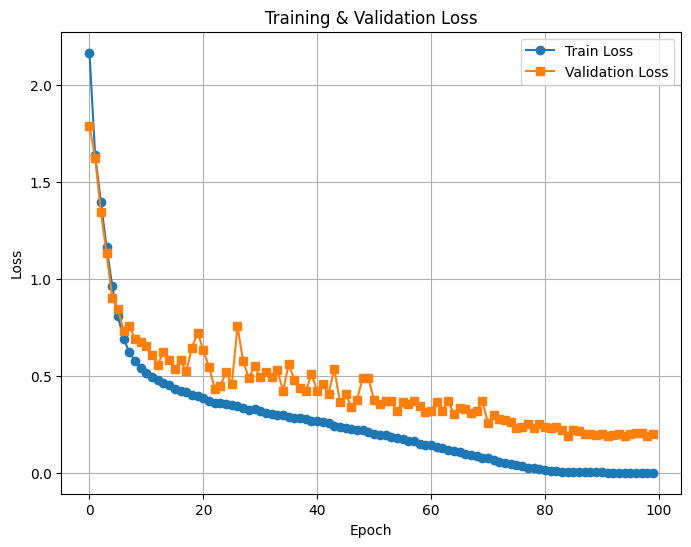

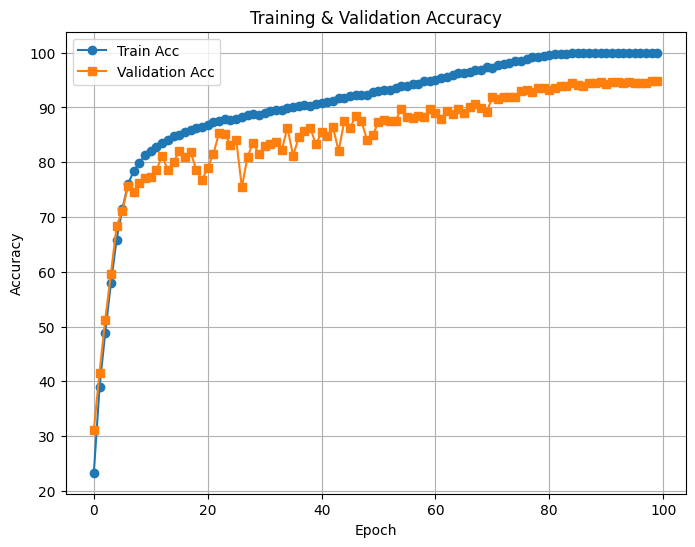

- Test Average Loss: 0.2014
- Test Accuracy: 94.56%


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import DataLoader, random_split, Subset
import time
# from utils import progress_bar

# 디바이스 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# 데이터셋 & 데이터로더 설정 (CIFAR-10)
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.2023, 0.1994, 0.2010])
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.2023, 0.1994, 0.2010])
])


# 데이터셋 다운로드
full_train_dataset = torchvision.datasets.CIFAR10(root="/content/drive/MyDrive/graduate/ResNet/dataset", train=True, transform=transform_train, download=True)
test_dataset = torchvision.datasets.CIFAR10(root="/content/drive/MyDrive/graduate/ResNet/dataset", train=False, transform=transform_test, download=True)

# Train/Validation split
train_size = int(0.9 * len(full_train_dataset))
val_size = len(full_train_dataset) - train_size

train_dataset, val_dataset = random_split(full_train_dataset, [train_size, val_size])
# val_dataset.dataset.transform = transform_test

# DataLoader 설정
batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

import torch.nn.init as init
import torch.nn.utils as nn_utils

def initialize_weights(model):
    for m in model.modules():
        if isinstance(m, nn.Conv2d):
            init.kaiming_normal_(m.weight, mode="fan_out", nonlinearity="relu")
            if m.bias is not None:
                init.constant_(m.bias, 0)
        elif isinstance(m, nn.BatchNorm2d):
            init.constant_(m.weight, 1)
            init.constant_(m.bias, 0)
        elif isinstance(m, nn.Linear):
            init.normal_(m.weight, 0, 0.01)
            init.constant_(m.bias, 0)

# 모델 초기화 적용
model = ResNet18().to(device)
initialize_weights(model)

start_epoch = 1
total_epoch = 100

def append_dropout(model, rate=0.2):
    for name, module in model.named_children():
        if len(list(module.children())) > 0:
            append_dropout(module)
        if isinstance(module, nn.ReLU):
            new = nn.Sequential(module, nn.Dropout2d(p=rate, inplace=False))
            setattr(model, name, new)


# append_dropout(model)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=total_epoch)
# from torch.optim.lr_scheduler import MultiStepLR
# scheduler2 = MultiStepLR(optimizer, milestones=[40, 60, 80], gamma=0.1)
# scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)
# optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-4)
# scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, 0.01, epochs=100,
#                                                 steps_per_epoch=len(train_loader))

# optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
# scheduler =  torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=0.00005,
#                                               step_size_up=5, max_lr=0.01,
#                                               gamma=0.5, mode='exp_range')


train_losses = []
val_losses = []
train_acc = []
val_acc = []

# Training
def train(epoch):
    # print('\nEpoch: %d' % epoch)
    model.train()
    train_loss = 0
    correct = 0
    total = 0
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

    avg_loss = train_loss / len(train_loader)
    train_losses.append(avg_loss)
    train_accuracy = 100 * correct / total
    train_acc.append(train_accuracy)
    print(f"Epoch [{epoch}/{total_epoch}]\n- Train Average Loss: {avg_loss:.4f}")
    print(f"- Train Accuracy: {train_accuracy:.2f}%")

    model.eval()
    val_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)

            val_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

            # print(batch_idx, len(testloader), 'Loss: %.3f | Acc: %.3f%% (%d/%d)'
            #              % (test_loss/(batch_idx+1), 100.*correct/total, correct, total))
    accuracy = 100 * correct / total
    avg_val_loss = val_loss / len(val_loader)
    val_losses.append(avg_val_loss)
    val_acc.append(accuracy)
    print(f"- Val Average Loss: {avg_val_loss:.4f}")
    print(f"- Val Accuracy: {accuracy:.2f}%")


def test(epoch):
    model.eval()
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

            # print(batch_idx, len(testloader), 'Loss: %.3f | Acc: %.3f%% (%d/%d)'
            #              % (test_loss/(batch_idx+1), 100.*correct/total, correct, total))
    accuracy = 100 * correct / total
    avg_test_loss = test_loss / len(test_loader)
    print(f"- Test Average Loss: {avg_test_loss:.4f}")
    print(f"- Test Accuracy: {accuracy:.2f}%")


    # # Save checkpoint.
    # acc = 100.*correct/total
    # if acc > best_acc:
    #     print('Saving..')
    #     state = {
    #         'net': net.state_dict(),
    #         'acc': acc,
    #         'epoch': epoch,
    #     }
    #     if not os.path.isdir('checkpoint'):
    #         os.mkdir('checkpoint')
    #     torch.save(state, './checkpoint/ckpt.pth')
    #     best_acc = acc

for epoch in range(start_epoch, start_epoch+total_epoch):
    train(epoch)
    scheduler.step()
plot_losses(train_losses, val_losses)
plot_acc(train_acc, val_acc)

test(epoch)

In [ ]:
!nvidia-smi

Sun Feb  2 12:39:07 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   66C    P0             28W /   70W |   14784MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:
import torch
torch.cuda.empty_cache()
torch.cuda.memory_summary(device=None, abbreviated=False)


'|===========================================================================|\n|                  PyTorch CUDA memory summary, device ID 0                 |\n|---------------------------------------------------------------------------|\n|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |\n|===========================================================================|\n|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |\n|---------------------------------------------------------------------------|\n| Allocated memory      |   1132 MiB |   2186 MiB |  63663 GiB |  63662 GiB |\n|       from large pool |   1035 MiB |   2082 MiB |  63342 GiB |  63341 GiB |\n|       from small pool |     97 MiB |    127 MiB |    320 GiB |    320 GiB |\n|---------------------------------------------------------------------------|\n| Active memory         |   1132 MiB |   2186 MiB |  63663 GiB |  63662 GiB |\n|       from large pool |   1035 MiB |   2082 MiB |

In [ ]:
import gc
gc.collect()

6178